# B08.1 Cell2cell interaction in Hippocampal 

- Script Function: Analyze the cell interaction of ligand-receptor pairs of interest in the hippocampal region.  
脚本功能：分析海马区感兴趣的配受体的细胞互作关系 
- Input: 1) h5ad file with annotated cell types 
输入：细胞类型注释后的h5ad
- Output: Differences in cell interactions among various cell types in the hippocampus after sleep deprivation. A significant reduction in cell adhesion factor interactions was observed in the cell interaction relationships from the dentate gyrus (DG) to CA3 and from CA3 to CA1.
输出：睡眠剥夺后，海马各类型细胞互作差异。在DG到CA3，CA3到CA1的细胞互作关系中，观察到明显的细胞粘附因子互作的减少。

## 0. Library importing 环境导入

In [1]:
library(CellChat)
library(patchwork)
options(stringsAsFactors = FALSE)
library(anndata)
library(Seurat)
library(seurath5ad)
library(jsonlite)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph

Warning message:
“package ‘igraph’ was built under R version 4.3.2”

Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2

Warning message:
“package ‘patchwork’ was built under R version 4.3.3”
Warning message:
“package ‘Seurat’ was built under R version 4.3.3”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.3.3”
Loading required package: sp

Warning message:
“package ‘sp’ was built under R version 4.3.2”

Attaching pa

## 1. cellchat ligand-receptor互作数据库设置

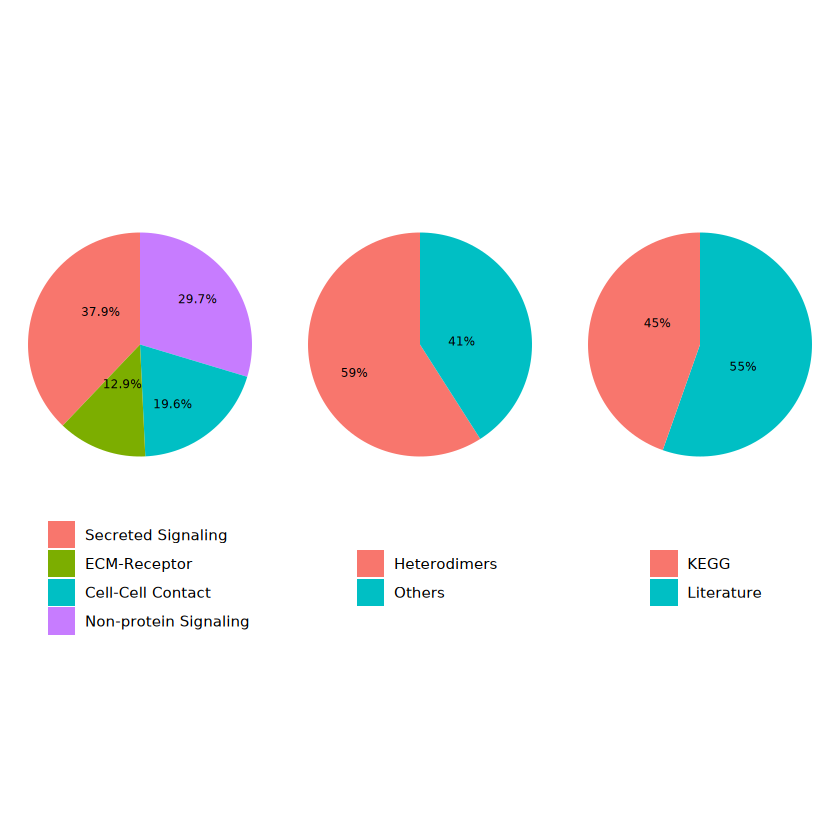

In [2]:
CellChatDB <- CellChatDB.mouse # use CellChatDB.human if running on human data
showDatabaseCategory(CellChatDB)

In [3]:
dplyr::glimpse(CellChatDB$interaction)

Rows: 3,379
Columns: 28
$ interaction_name         <chr> "TGFB1_TGFBR1_TGFBR2", "TGFB2_TGFBR1_TGFBR2",…
$ pathway_name             <chr> "TGFb", "TGFb", "TGFb", "TGFb", "TGFb", "TGFb…
$ ligand                   <chr> "Tgfb1", "Tgfb2", "Tgfb3", "Tgfb1", "Tgfb1", …
$ receptor                 <chr> "TGFbR1_R2", "TGFbR1_R2", "TGFbR1_R2", "ACVR1…
$ agonist                  <chr> "TGFb agonist", "TGFb agonist", "TGFb agonist…
$ antagonist               <chr> "TGFb antagonist", "TGFb antagonist", "TGFb a…
$ co_A_receptor            <chr> "", "", "", "", "", "", "", "", "", "", "", "…
$ co_I_receptor            <chr> "TGFb inhibition receptor", "TGFb inhibition …
$ evidence                 <chr> "KEGG: mmu04350", "KEGG: mmu04350", "KEGG: mm…
$ annotation               <chr> "Secreted Signaling", "Secreted Signaling", "…
$ interaction_name_2       <chr> "Tgfb1 - (Tgfbr1+Tgfbr2)", "Tgfb2  - (Tgfbr1+…
$ is_neurotransmitter      <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FAL…
$ ligand.symbol 

In [4]:
CellChatDB.use <- subsetDB(CellChatDB, search = "Cell-Cell Contact", key = "annotation") # use Secreted Signaling Non-protein Signaling

由于我们关注的Gpc4-Lrrmt4的相互关系在cellchatv2的数据库中不存在，因此我们需要手动添加上去，更新内容为CellChatDB.use$geneInfo和CellChatDB.use$interaction。由于这两个蛋白是单独起作用的，因此不需要增加其他内容

In [5]:
json_data <- '{
  "EntryID.uniprot": "P51655",
  "Symbol": "Gpc4",
  "Synonym": "K-glypican",
  "Reviewed": "UniProtKB reviewed (Swiss-Prot)",
  "EntryName": "GPC4_MOUSE",
  "ProteinName": "Glypican-4; Secreted glypican-4",
  "Keywords": "Cell membrane; Membrane; Secreted; Reference proteome; Signal; Glypican family; Regulation of neurotransmitter receptor localization; Regulation of presynapse assembly; Synaptic membrane adhesion; Wnt signaling pathway; GAG synthesis; HS-GAG biosynthesis; HS-GAG degradation; Retinoid metabolism and transport",
  "Location": "Cell membrane; Secreted, extracellular space; collagen-containing extracellular matrix; external side of plasma membrane; extracellular space; glutamatergic synapse; Golgi lumen; presynaptic membrane; synapse"
}'

# 将JSON数据转换为数据框
new_df <- as.data.frame(fromJSON(json_data), stringsAsFactors = FALSE)

# 将新的数据框添加到现有的数据框中
CellChatDB.use$geneInfo <- rbind(CellChatDB.use$geneInfo,new_df)

tail(CellChatDB.use$geneInfo,1)

,EntryID.uniprot,Symbol,Synonym,Reviewed,EntryName,ProteinName,Keywords,Location
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
25521,P51655,Gpc4,K-glypican,UniProtKB reviewed (Swiss-Prot),GPC4_MOUSE,Glypican-4; Secreted glypican-4,Cell membrane; Membrane; Secreted; Reference proteome; Signal; Glypican family; Regulation of neurotransmitter receptor localization; Regulation of presynapse assembly; Synaptic membrane adhesion; Wnt signaling pathway; GAG synthesis; HS-GAG biosynthesis; HS-GAG degradation; Retinoid metabolism and transport,"Cell membrane; Secreted, extracellular space; collagen-containing extracellular matrix; external side of plasma membrane; extracellular space; glutamatergic synapse; Golgi lumen; presynaptic membrane; synapse"


In [6]:
json_data <-  '{
    "interaction_name": "GPC4_LRRTM4",
    "pathway_name": "GPC",
    "ligand": "Gpc4",
    "receptor": "Lrrtm4",
    "agonist": "",
    "antagonist": "",
    "co_A_receptor": "",
    "co_I_receptor": "",
    "evidence": "PMID:23911104;PMID:23911103;",
    "annotation": "Cell-Cell Contact",
    "interaction_name_2": "Gpc4 - Lrrtm4",
    "is_neurotransmitter": false,
    "ligand.symbol": "Gpc4",
    "ligand.family": "Glypican",
    "ligand.location": "Presynaptic cell membrane",
    "ligand.keyword": "Cell membrane; Membrane; Secreted; Reference proteome; Signal; Glypican family; Regulation of neurotransmitter receptor localization; Regulation of presynapse assembly; Synaptic membrane adhesion; Wnt signaling pathway; GAG synthesis; HS-GAG biosynthesis; HS-GAG degradation; Retinoid metabolism and transport",
    "ligand.secreted_type": "",
    "ligand.transmembrane": true,
    "receptor.symbol": "Lrrtm4",
    "receptor.family": "LRRTM",
    "receptor.location": "Postsynaptic cell membrane, Cell membrane",
    "receptor.keyword": "Membrane, Leucine-rich repeat, Signal, Reference proteome, Cell membrane, Transmembrane helix, Transmembrane, Postsynaptic cell membrane, Alternative splicing, Synapse, Repeat, Glycoprotein",
    "receptor.surfaceome_main": "Miscellaneous",
    "receptor.surfaceome_sub": "LRRC;Other",
    "receptor.adhesome": "",
    "receptor.secreted_type": "",
    "receptor.transmembrane": true,
    "version": "self-defined"
}'

# 将JSON数据转换为数据框
new_df <- as.data.frame(fromJSON(json_data), stringsAsFactors = FALSE)

# 记录现有数据框的行数
old_rows <- nrow(CellChatDB.use$interaction)

# 将新的数据框添加到现有的数据框中
CellChatDB.use$interaction <- rbind(CellChatDB.use$interaction,new_df)

# 确定新添加行的索引范围
new_row_index <- (old_rows + 1):nrow(CellChatDB.use$interaction)

# 为新添加的行设置行名
rownames(CellChatDB.use$interaction)[new_row_index] <- 'GPC4_LRRTM4'

tail(CellChatDB.use$interaction,1)

,interaction_name,pathway_name,ligand,receptor,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,⋯,receptor.symbol,receptor.family,receptor.location,receptor.keyword,receptor.surfaceome_main,receptor.surfaceome_sub,receptor.adhesome,receptor.secreted_type,receptor.transmembrane,version
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>
GPC4_LRRTM4,GPC4_LRRTM4,GPC,Gpc4,Lrrtm4,,,,,PMID:23911104;PMID:23911103;,Cell-Cell Contact,⋯,Lrrtm4,LRRTM,"Postsynaptic cell membrane, Cell membrane","Membrane, Leucine-rich repeat, Signal, Reference proteome, Cell membrane, Transmembrane helix, Transmembrane, Postsynaptic cell membrane, Alternative splicing, Synapse, Repeat, Glycoprotein",Miscellaneous,LRRC;Other,,,TRUE,self-defined


## 3. Data importing 数据读入

### 3.1 Import data of the control group 导入对照组数据

#### 3.1.1 Read in the data, merge them into a single Seurat object, and standardize it.   
  读入数据并合并为一个Seurat对象并标准化

In [7]:
# Create an empty list to store data 创建一个空的列表来存储数据
data_dict <- list()

# Define a list of file names to be processed 定义要处理的文件名列表
file_names <- c('CT1', 'CT2', 'CT3') 

# Loop through each file, read and process it 循环读取每个文件并处理
for (i in file_names) {
  # Read the Seurat object with LoadRawH5ad. Guide (https://github.com/yiji-stomics/seurath5ad) 读取 Seurat 对象 
  indata <- LoadRawH5ad(paste0("./cellchat/", i, ".Hippocampal.h5ad"))

  # Store the processed Seurat object in the list 将处理后的 Seurat 对象存储到列表中
  indata@meta.data$orig.ident <- i
  data_dict[[i]] <- indata
}

# Merge all Seurat objects 合并所有 Seurat 对象
ctobj <- merge(data_dict[[1]], y = data_dict[2:length(data_dict)], add.cell.ids = file_names, project = "hippo", merge.data = TRUE)
rm(data_dict)
rm(indata)

# In Seurat version 5, if multiple files are read separately, the merge function does not merge the expression matrices of each sample. 
# Each sample remains an independent matrix in the Seurat object. An additional JoinLayers() function is needed to completely merge them.
#Seurat的V5版本，多个文件如果是分开读取的，merge函数并没有把每个样品的表达量矩阵merge，
#在Seurat对象中每个样品仍然是独立的矩阵，需要使用额外JoinLayers()函数将其彻底融合
ctobj <- JoinLayers(ctobj)

# Rename all images
# 重命名所有的images
names(ctobj@images) <- file_names

# Print the cell frequency table of the Sample namecolumn
# 打印样本列的细胞频率表
print(table(ctobj@meta.data$orig.ident))

# SCTransform SCTransform校正
ctobj@meta.data$orig.ident <- factor(ctobj@meta.data$orig.ident)
print(ctobj)

# Run sctransform. The batch information is stored in orig.ident. After completion, the active assay is SCT.
# 运行 sctransform，批次信息存于 orig.ident，完成后 active assay 为 SCT。
ctobj <- SCTransform(ctobj, assay = "Spatial", vars.to.regress = "orig.ident", verbose = FALSE)

Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”
Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”
Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”
Warning message:
“Key ‘slice_’ taken, using ‘slice2_’ instead”
Warning message:
“Key ‘slice_’ taken, using ‘slice3_’ instead”



  CT1   CT2   CT3 
10073 10462  6776 
An object of class Seurat 
17557 features across 27311 samples within 1 assay 
Active assay: Spatial (17557 features, 0 variable features)
 1 layer present: counts
 3 images present: CT1, CT2, CT3


#### 3.1.2 Select the cell types of interest 挑选感兴趣的细胞类型

In [8]:
# Select the cell types of interest
#选取感兴趣的细胞类型

chooseCellType = c("016 CA1-ProS Glut",
         "017 CA3 Glut",
         "025 CA2-FC-IG Glut",
         "037 DG Glut",
         "038 DG-PIR Ex IMN",
         "318 Astro-NT NN",
         "319 Astro-TE NN",
         "326 OPC NN ","C333 Endo NN",
         "334 Microglia NN")

filter_data <- ctobj@meta.data %>%
  filter(celltype %in% chooseCellType)

# Subset the Seurat object to keep the cells that meet the criteria
# 子集化 Seurat 对象，保留符合条件的细胞
ctobj <- subset(ctobj, cells = rownames(filter_data))

# View the results
# 查看结果
print(ctobj)

Warning message:
“Not validating Seurat objects”
Warning message:
“Not validating Seurat objects”
Warning message:
“Not validating Seurat objects”


An object of class Seurat 
34630 features across 23520 samples within 2 assays 
Active assay: SCT (17073 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: Spatial
 3 images present: CT1, CT2, CT3


#### 3.1.3 Generate a CellChat object 生成cellchat对象

In [9]:
# Prepare input data for CelChat analysis
# 为CellChat分析准备输入数据
CT_data.input = Seurat::GetAssayData(ctobj, slot = "data", assay = "SCT") 
ctobj$samples <- factor(ctobj$orig.ident)

# define the meta data
# 定义meta信息
ctobj@meta.data$celltype <- factor(ctobj@meta.data$celltype)

unique(ctobj$celltype) # check the cell labels 检查cell标签
unique(filter_data$samples) # check the sample labels 检查样本标签

# Read the spatial coordinates
# 读取空间坐标
#CT_spatial.locs <- ctobj@meta.data[, c("x", "y")]

# Read the spatial conversion factors. The ratio is set to 0.5 because the resolution of Stereo - seq is 500nm, which means the distance between bin 1 and bin 1 is 500nm. 
# The tol is set to 50 considering the signal diffusion distance and can be adjusted by users.
#读取空间转换因子，ration设置为0.5是因为stereoseq的分辨率为500nm，也就是bin1与bin1的距离是500nm, tol设置为50，是考虑到信号扩散距离，可自行调整
#CT_spatial.factors <- data.frame(ratio = 0.5, tol = 100/2)

# Generate a CellChat object. Since the range of axon lengths of nerve cells is uncertain, 
# single cell based calculation is used for cell - cell communication analysis.
# 生成cellchat对象，由于神经细胞的轴突长度范围不确定，因此采用单细胞方式进行细胞通讯的计算
cellchat.CT <- createCellChat(object = CT_data.input, meta = ctobj@meta.data, group.by = "celltype", datatype="RNA")

# Integrate the database into the CellChat object
#整合数据库到cellchat对象上
cellchat.CT@DB <- CellChatDB.use

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


[1] 016 CA1-ProS Glut  038 DG-PIR Ex IMN  319 Astro-TE NN    037 DG Glut       
[5] 318 Astro-NT NN    017 CA3 Glut       025 CA2-FC-IG Glut 334 Microglia NN  
8 Levels: 016 CA1-ProS Glut 017 CA3 Glut 025 CA2-FC-IG Glut ... 334 Microglia NN

NULL

[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  016 CA1-ProS Glut, 017 CA3 Glut, 025 CA2-FC-IG Glut, 037 DG Glut, 038 DG-PIR Ex IMN, 318 Astro-NT NN, 319 Astro-TE NN, 334 Microglia NN 


### 3.2 Import data of the experimental group 导入实验组数据

#### 3.2.1 Read in the data, merge them into a single Seurat object, and standardize it.   
读入数据并合并为一个Seurat对象并标准

In [10]:
# Create an empty list to store data 创建一个空的列表来存储数据
data_dict <- list()

# Define a list of file names to be processed 定义要处理的文件名列表
file_names <- c('EP1', 'EP2', 'EP3')

# Loop through each file, read and process it 循环读取每个文件并处理
for (i in file_names) {
  # Read the Seurat object with LoadRawH5ad. Guide (https://github.com/yiji-stomics/seurath5ad) 读取 Seurat 对象 
  indata <- LoadRawH5ad(paste0("./cellchat/", i, ".Hippocampal.h5ad"))

  # Store the processed Seurat object in the list 将处理后的 Seurat 对象存储到列表中
  indata@meta.data$orig.ident <- i
  data_dict[[i]] <- indata
}

# Merge all Seurat objects 合并所有 Seurat 对象
epobj <- merge(data_dict[[1]], y = data_dict[2:length(data_dict)], add.cell.ids = file_names, project = "hippo", merge.data = TRUE)
rm(data_dict)
rm(indata)

# In Seurat version 5, if multiple files are read separately, the merge function does not merge the expression matrices of each sample. 
# Each sample remains an independent matrix in the Seurat object. An additional JoinLayers() function is needed to completely merge them.
# Seurat的V5版本，多个文件如果是分开读取的，merge函数并没有把每个样品的表达量矩阵merge，
# 在Seurat对象中每个样品仍然是独立的矩阵，需要使用额外JoinLayers()函数将其彻底融合
epobj <- JoinLayers(epobj)

# Rename all images
# 重命名所有的images
names(epobj@images) <- file_names

# Print the cell frequency table of the Sample namecolumn
# 打印样本列的细胞频率表
print(table(epobj@meta.data$orig.ident))

# SCTransform SCTransform校正
epobj@meta.data$orig.ident <- factor(epobj@meta.data$orig.ident)
print(epobj)

# Run sctransform. The batch information is stored in orig.ident. After completion, the active assay is SCT.
# 运行 sctransform，批次信息存于 orig.ident，完成后 active assay 为 SCT。
epobj <- SCTransform(epobj, assay = "Spatial", vars.to.regress = "orig.ident", verbose = FALSE)

Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”
Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”
Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”
Warning message:
“Key ‘slice_’ taken, using ‘slice2_’ instead”
Warning message:
“Key ‘slice_’ taken, using ‘slice3_’ instead”



  EP1   EP2   EP3 
12502  8553  9304 
An object of class Seurat 
17540 features across 30359 samples within 1 assay 
Active assay: Spatial (17540 features, 0 variable features)
 1 layer present: counts
 3 images present: EP1, EP2, EP3


#### 3.2.2 Select the cell types of interest 挑选感兴趣的细胞类型

In [11]:
# Select the cell types of interest
#选取感兴趣的细胞类型

filter_data <- epobj@meta.data %>%
  filter(celltype %in% c("016 CA1-ProS Glut",
         "017 CA3 Glut",
         "025 CA2-FC-IG Glut",
         "037 DG Glut",
         "038 DG-PIR Ex IMN",
         "318 Astro-NT NN",
         "319 Astro-TE NN",
         "326 OPC NN ","C333 Endo NN",
         "334 Microglia NN"))

# Subset the Seurat object to keep the cells that meet the criteria
# 子集化 Seurat 对象，保留符合条件的细胞
epobj <- subset(epobj, cells = rownames(filter_data))

# View the results
# 查看结果
print(epobj)

Warning message:
“Not validating Seurat objects”
Warning message:
“Not validating Seurat objects”
Warning message:
“Not validating Seurat objects”


An object of class Seurat 
34601 features across 25757 samples within 2 assays 
Active assay: SCT (17061 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: Spatial
 3 images present: EP1, EP2, EP3


#### 3.2.3 Generate a CellChat object 生成cellchat对象

In [12]:
# Prepare input data for CelChat analysis
# 为CellChat分析准备输入数据
EP_data.input = Seurat::GetAssayData(epobj, slot = "data", assay = "SCT")

# define the meta data
# 定义meta信息
epobj$samples <- factor(epobj$orig.ident)
epobj@meta.data$celltype <- factor(epobj@meta.data$celltype)

unique(ctobj$celltype) # check the cell labels 检查cell标签
unique(filter_data$samples) # check the sample labels 检查样本标签

# Read the spatial coordinates
# 读取空间坐标
# EP_spatial.locs <- epobj@meta.data[, c("x", "y")]

# Read the spatial conversion factors. The ratio is set to 0.5 because the resolution of Stereo - seq is 500nm, which means the distance between bin 1 and bin 1 is 500nm. 
# The tol is set to 50 considering the signal diffusion distance and can be adjusted by users.
#读取空间转换因子，ration设置为0.5是因为stereoseq的分辨率为500nm，也就是bin1与bin1的距离是500nm, tol设置为50，是考虑到信号扩散距离，可自行调整
# EP_spatial.factors <- data.frame(ratio = 0.5, tol = 100/2)


# Generate a CellChat object. Since the range of axon lengths of nerve cells is uncertain, 
# single cell based calculation is used for cell - cell communication analysis.
#生成cellchat对象，由于神经细胞的轴突长度范围不确定，因此采用单细胞方式进行细胞通讯的计算
cellchat.EP <- createCellChat(object = EP_data.input, meta = epobj@meta.data, group.by = "celltype", datatype="RNA")
cellchat.EP@DB <- CellChatDB.use

[1] 016 CA1-ProS Glut  038 DG-PIR Ex IMN  319 Astro-TE NN    037 DG Glut       
[5] 318 Astro-NT NN    017 CA3 Glut       025 CA2-FC-IG Glut 334 Microglia NN  
8 Levels: 016 CA1-ProS Glut 017 CA3 Glut 025 CA2-FC-IG Glut ... 334 Microglia NN

NULL

[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  016 CA1-ProS Glut, 017 CA3 Glut, 025 CA2-FC-IG Glut, 037 DG Glut, 038 DG-PIR Ex IMN, 318 Astro-NT NN, 319 Astro-TE NN, 334 Microglia NN 


## 4. Preprocessing of expression data for cell-cell communication  cell-cell communication的表达数据的前处理

In [13]:
cellchat.CT <- subsetData(cellchat.CT)
future::plan("multisession", workers = 3) 
cellchat.CT <- identifyOverExpressedGenes(cellchat.CT)
cellchat.CT <- identifyOverExpressedInteractions(cellchat.CT, variable.both = F)

The number of highly variable ligand-receptor pairs used for signaling inference is 357 


In [96]:
cellchat.CT@var.features$features.info %>%
  filter(features %in% c("Gpc4","Lrrtm4",'Ptprs','Lrrtm3'))

features,clusters,avgExpr,logFC,auc,pvalues,pvalues.adj,pct.1,pct.2
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lrrtm4,037 DG Glut,0.45149217,0.33978551,0.6590583,0.000000e+00,0.000000e+00,43.705567,13.904152
Ptprs,017 CA3 Glut,0.33277432,0.13877412,0.5848433,3.609218e-97,7.373117e-96,40.875912,24.090590
Gpc4,037 DG Glut,0.04591207,0.03664619,0.5231055,1.914561e-89,2.028017e-88,5.884283,1.265911
Ptprs,016 CA1-ProS Glut,0.26734881,0.06552629,0.5425706,7.807604e-32,6.379928e-31,33.635980,24.866908
Lrrtm3,037 DG Glut,0.02586209,0.01102809,0.5069054,6.715974e-11,1.829303e-10,3.412447,2.031022
Ptprs,025 CA2-FC-IG Glut,0.25994171,0.04788936,0.5347206,8.678666e-09,6.364355e-08,33.791209,26.160261
Lrrtm4,038 DG-PIR Ex IMN,0.27207696,0.02924821,0.5196283,1.475118e-02,5.859498e-02,29.677419,25.346230


In [15]:
cellchat.EP <- subsetData(cellchat.EP) # This step is necessary even if using the whole database
future::plan("multisession", workers = 3) 
cellchat.EP <- identifyOverExpressedGenes(cellchat.EP)
cellchat.EP <- identifyOverExpressedInteractions(cellchat.EP, variable.both = F)

The number of highly variable ligand-receptor pairs used for signaling inference is 352 


In [16]:
cellchat.EP@var.features$features.info %>%
  filter(features %in% c("Gpc4","Lrrtm4",'Ptprs'))

features,clusters,avgExpr,logFC,auc,pvalues,pvalues.adj,pct.1,pct.2
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lrrtm4,037 DG Glut,0.28417430,0.19288000,0.6032266,0.000000e+00,0.000000e+00,31.748832,11.934003
Ptprs,017 CA3 Glut,0.31757926,0.12431498,0.5779358,1.280281e-95,2.432534e-94,39.882214,24.363146
Gpc4,037 DG Glut,0.03180335,0.02374481,0.5152751,2.293358e-57,1.675915e-56,4.172289,1.116487
Ptprs,016 CA1-ProS Glut,0.27729499,0.07878416,0.5519332,4.793922e-49,4.407315e-48,35.580975,24.843554
Ptprs,025 CA2-FC-IG Glut,0.28254882,0.07396215,0.5472276,5.738966e-18,7.111328e-17,35.797665,26.254278
Lrrtm4,038 DG-PIR Ex IMN,0.20064012,0.03862367,0.5214290,1.070697e-03,5.983308e-03,23.294858,19.194485


## 5. Inference of cell-cell communication networks 细胞间通讯网络的推测

truncatedMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2025-02-17 18:34:16.317818]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2025-02-17 18:35:20.293117]"


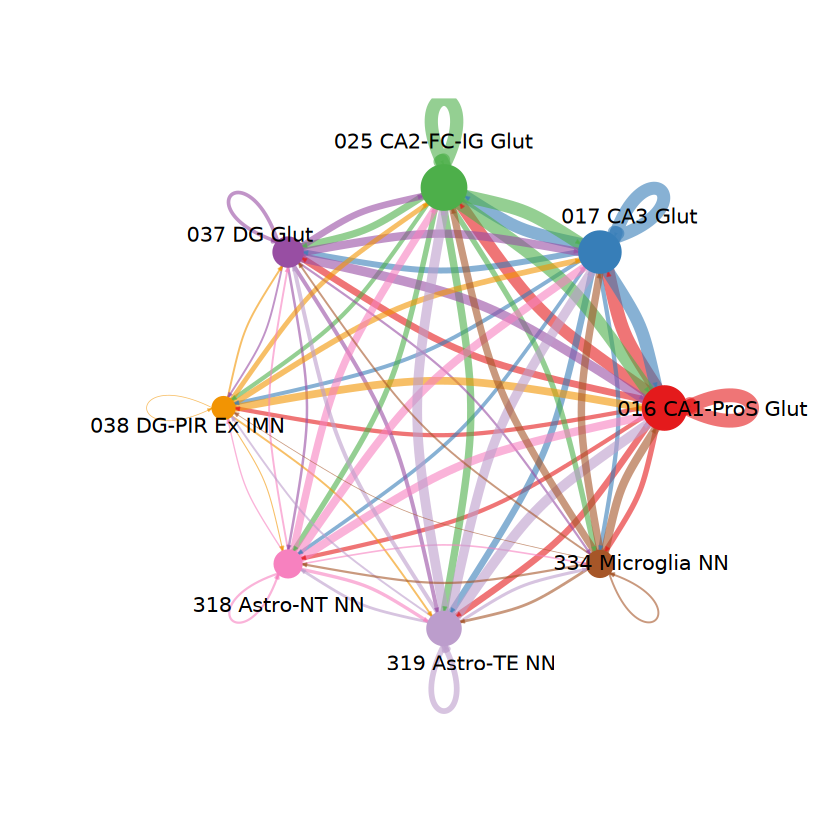

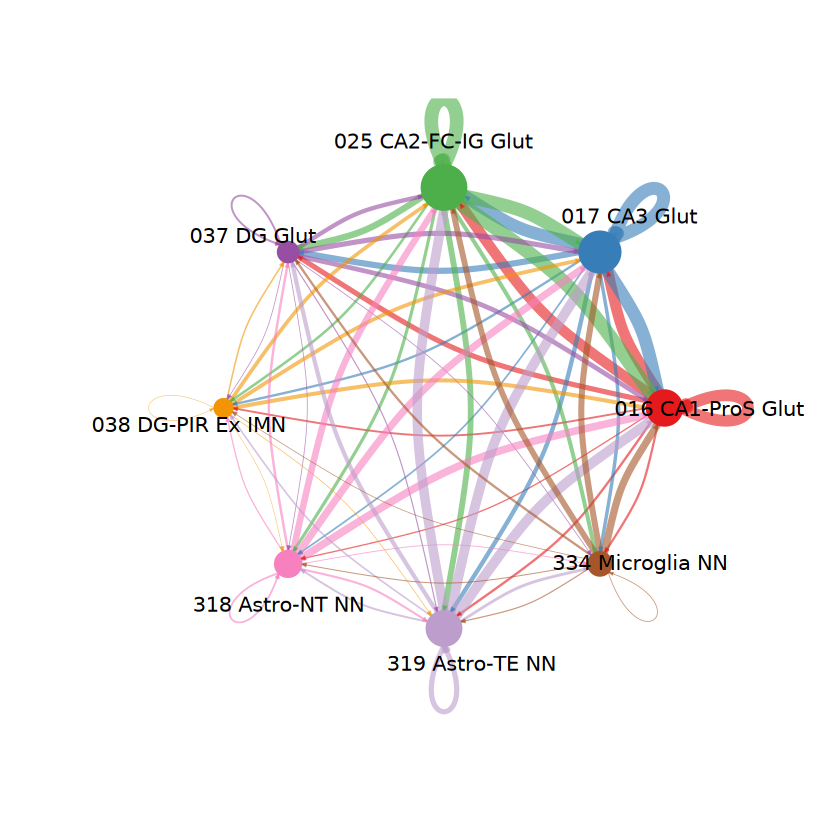

In [17]:
cellchat.CT <- computeCommunProb(cellchat.CT, type = "truncatedMean")
cellchat.CT <- filterCommunication(cellchat.CT, min.cells = 10)
cellchat.CT <- computeCommunProbPathway(cellchat.CT)
cellchat.CT <- aggregateNet(cellchat.CT)
groupSize <- as.numeric(table(cellchat.CT@idents))
netCircleNum_CT <- netVisual_circle(cellchat.CT@net$count, vertex.weight = rowSums(cellchat.CT@net$count), weight.scale = T, label.edge= F, title.name = "Number of interactions")
netCircleWeight_CT <- netVisual_circle(cellchat.CT@net$weight, vertex.weight = rowSums(cellchat.CT@net$weight), weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

truncatedMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2025-02-17 18:35:22.838106]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2025-02-17 18:36:23.596798]"


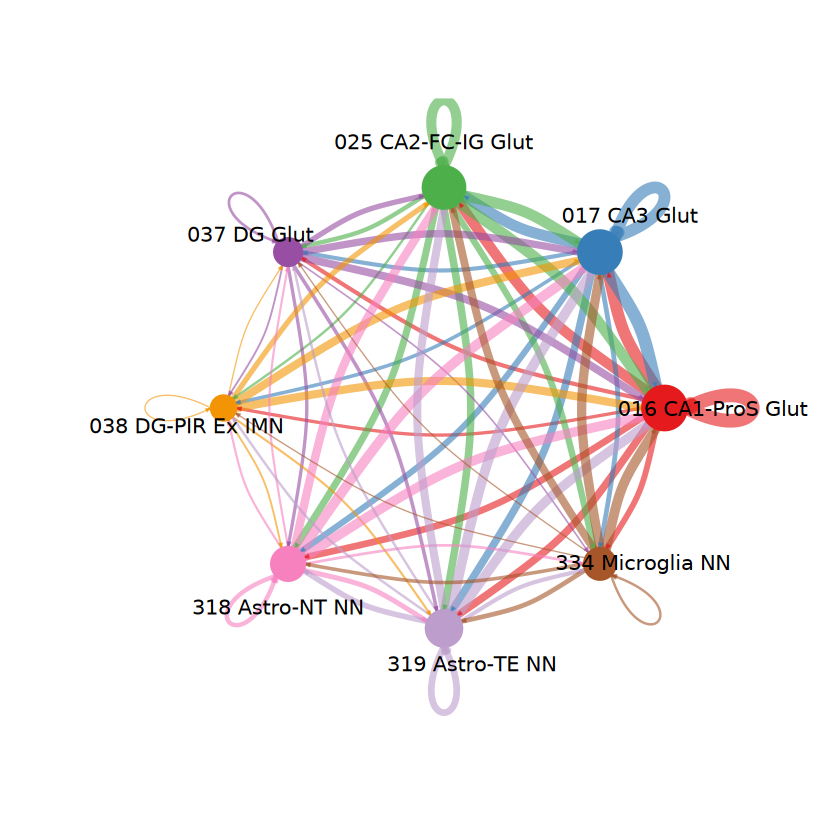

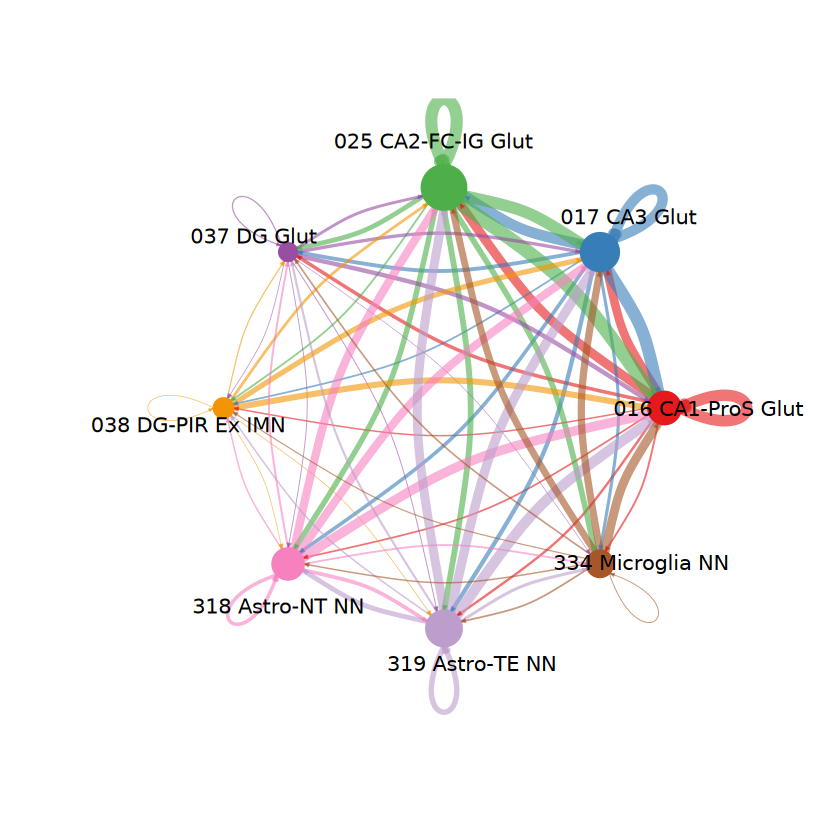

In [18]:
cellchat.EP <- computeCommunProb(cellchat.EP, type = "truncatedMean")
cellchat.EP <- filterCommunication(cellchat.EP, min.cells = 10)
cellchat.EP <- computeCommunProbPathway(cellchat.EP)
cellchat.EP <- aggregateNet(cellchat.EP)
groupSize <- as.numeric(table(cellchat.EP@idents))
netCircleNum_EP <- netVisual_circle(cellchat.EP@net$count, vertex.weight = rowSums(cellchat.EP@net$count), weight.scale = T, label.edge= F, title.name = "Number of interactions")
netCircleWeight_EP <- netVisual_circle(cellchat.EP@net$weight, vertex.weight = rowSums(cellchat.EP@net$weight), weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

In [19]:
#计算网络中心性分数并可视化
# Compute the network centrality scores
cellchat.CT <- netAnalysis_computeCentrality(cellchat.CT, slot.name = "netP") # the slot 'netP' means the inferred intercellular communication network of signaling pathways
par(mfrow=c(1,1))
cellchat.EP <- netAnalysis_computeCentrality(cellchat.EP, slot.name = "netP") # the slot 'netP' means the inferred intercellular communication network of signaling pathways

存储cellchat对象

In [20]:
saveRDS(cellchat.CT,file="./processdata/08.1.hippocampals_CT.rds")

In [21]:
saveRDS(cellchat.EP,file="./processdata/08.1.hippocampals_EP.rds")

## 5. Comparisson between Different Datasets 不同组别之间比较

In [22]:
cellchat.CT <- readRDS("./processdata/08.1.hippocampals_CT.rds")
cellchat.EP <- readRDS("./processdata/08.1.hippocampals_EP.rds")

In [23]:
object.list <- list(CT = cellchat.CT, EP = cellchat.EP)
cellchat <- mergeCellChat(object.list, add.names = names(object.list))
#> Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.
cellchat

Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



An object of class CellChat created from a merged object with multiple datasets 
 285 signaling genes.
 49277 cells. 
CellChat analysis of single cell RNA-seq data! 

### 5.1 Compare the total number of interactions and interaction strength 比较互作数量和互作强度 

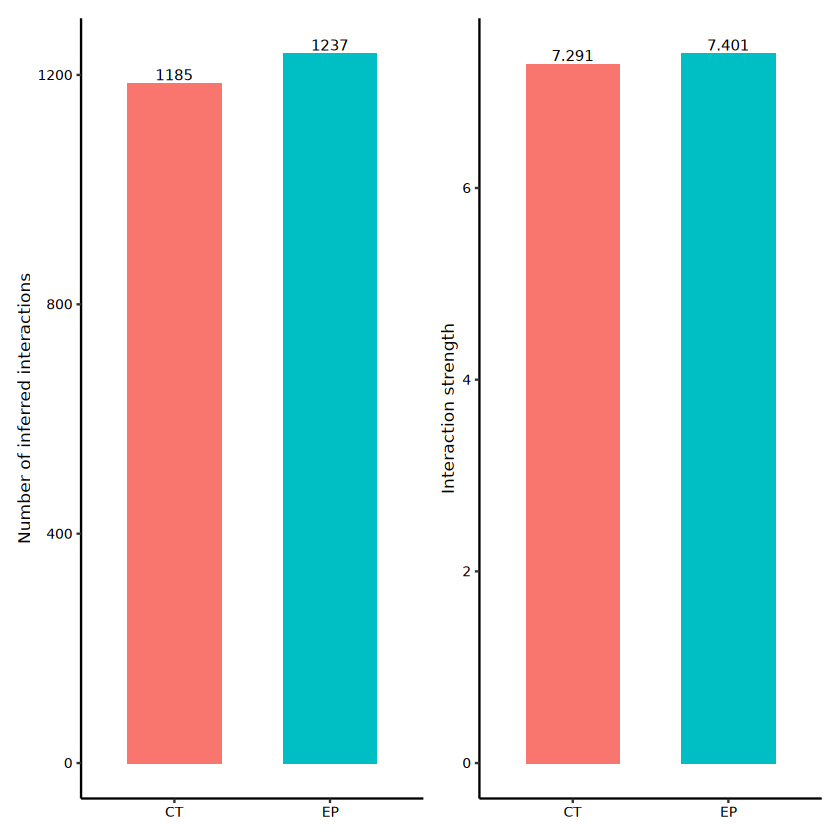

In [24]:
ptm = Sys.time()
gg1 <- compareInteractions(cellchat, show.legend = F, group = c(1,2))
gg2 <- compareInteractions(cellchat, show.legend = F, group = c(1,2), measure = "weight")
gg1 + gg2

### 5.2 Circle plot showing differential number of interactions or interaction strength among different cell populations across two datasets 比较不同组别间不同细胞之间的互作强度和互作数量

The differential number of interactions or interaction strength in the cell-cell communication network between two datasets can be visualized using circle plot,  where <span style="color: red;">red</span> (or <span style="color: blue;">blue</span>) represents <span style="color: red;">increased</span> (or <span style="color: blue;">decreased</span>) signaling in the second dataset compared to the first one.    
两个数据集之间细胞间通讯网络中相互作用数量或相互作用强度的差异，可以通过圆形图进行可视化展示。在圆形图中，<span style="color: red;">红色</span>（或<span style="color: red;">蓝色</span>）表示与第一个数据集相比，第二个数据集中信号<span style="color: red;">增加</span>（或<span style="color: blue;">减少</span>）。

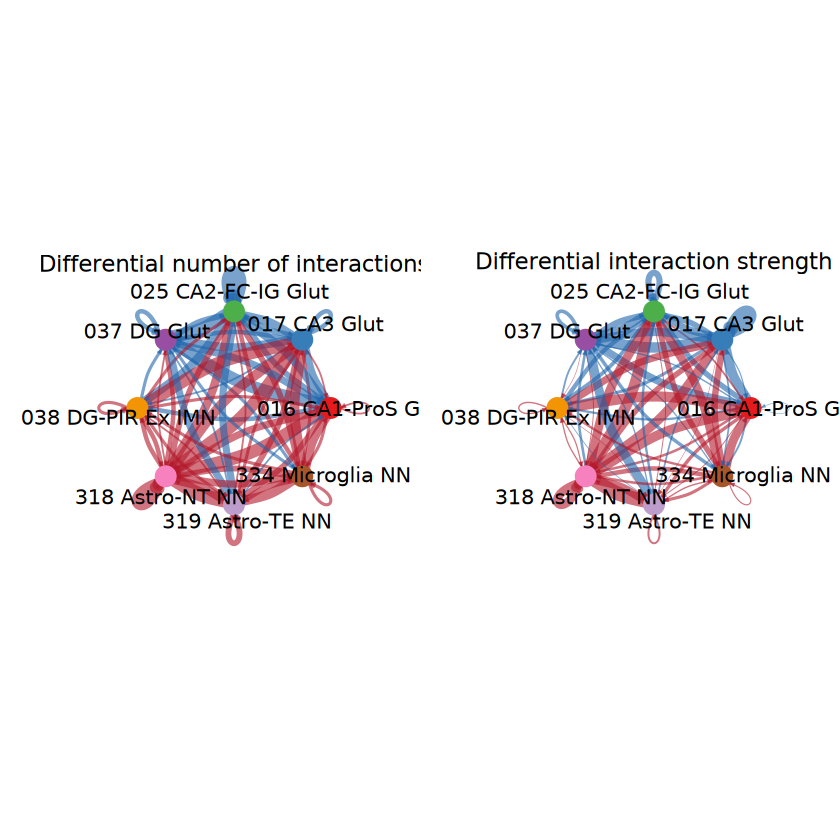

In [25]:
par(mfrow = c(1,2), xpd=TRUE)
netCircleDiffNum <- netVisual_diffInteraction(cellchat, weight.scale = T)
netCircleDiffWeight <- netVisual_diffInteraction(cellchat, weight.scale = T, measure = "weight")

### 5.3 Heatmap showing differential number of interactions or interaction strength among different cell populations across two datasets 显示两个数据集之间不同细胞群体间相互作用数量或相互作用强度差异的热图

CellChat can also show differential number of interactions or interaction strength in greater details using a heatmap. The top colored bar plot represents the sum of each column of the absolute values displayed in the heatmap (incoming signaling). The right colored bar plot represents the sum of each row of the absolute values (outgoing signaling). Therefore, the bar height indicates the degree of change in terms of the number of interactions or interaction strength between the two conditions. In the colorbar, <span style="color: red;">red</span> (or <span style="color: blue;">blue</span>) represents <span style="color: red;">increased</span> (or <span style="color: blue;">decreased</span>) signaling in the second dataset compared to the first one.  
CellChat 还可以使用热图更详细地展示相互作用数量或相互作用强度的差异。顶部的彩色条形图表示热图中显示的每列绝对值之和（传入信号）。右侧的彩色条形图表示每行绝对值之和（传出信号）。因此，条形的高度表示两种条件之间相互作用数量或相互作用强度的变化程度。在颜色条中，span style="color: red;">红色</span>（或<span style="color: red;">蓝色</span>）表示与第一个数据集相比，第二个数据集中信号<span style="color: red;">增加</span>（或<span style="color: blue;">减少</span>）。

Do heatmap based on a merged object 




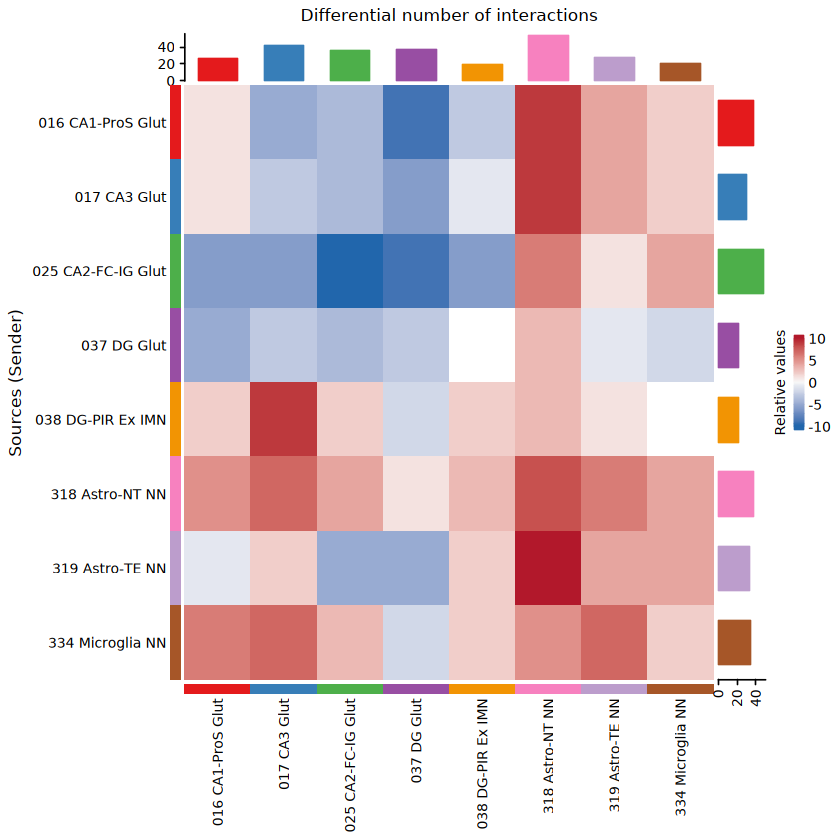

In [26]:
netHeatmapDiffNum <- netVisual_heatmap(cellchat)
netHeatmapDiffNum

Do heatmap based on a merged object 




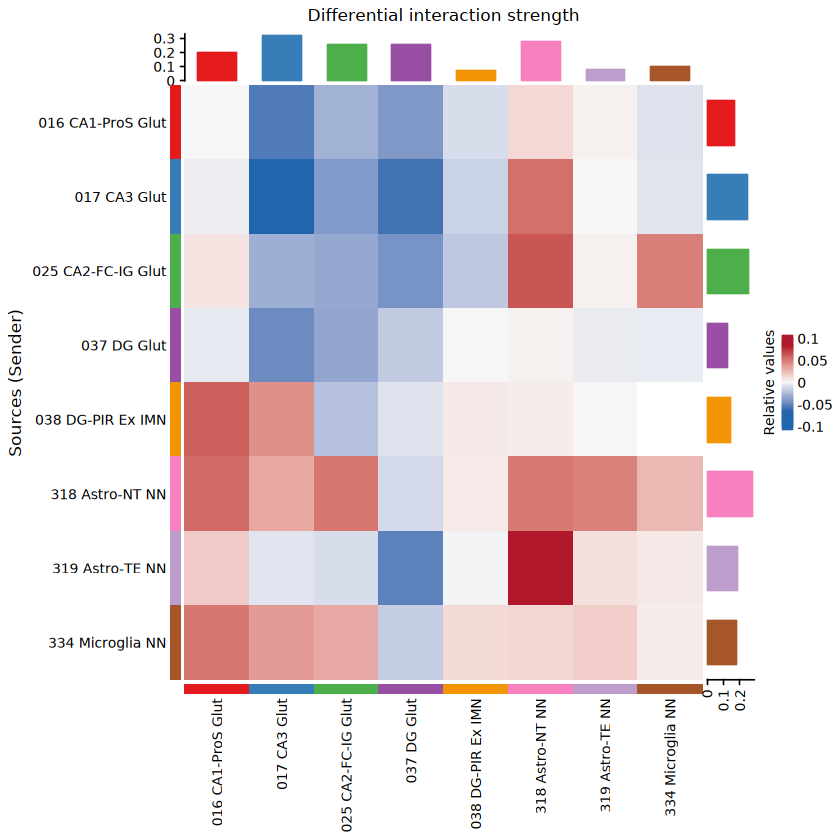

In [27]:
netHeatmapDiffWeight <- netVisual_heatmap(cellchat, measure = "weight")
netHeatmapDiffWeight

We can observe that in the interactions of pyramidal neurons, the interaction strength and number are reduced in sleep - deprived mice, while the interaction number and strength of glial cells or microglia are increased in sleep - deprived mice. This is consistent with the results of multiple studies [1,2]. Yang et al. found that 72 - hour sleep deprivation reduced the voltage - gated sodium channels and hyperpolarization - activated cation currents of CA1 pyramidal neurons, leading to a decrease in neuronal excitability and affecting the learning and memory process. This partially explains the mechanism by which PSD affects membrane excitability. Havekes et al. reported that 5 - hour sleep deprivation significantly reduced the number and length of dendritic spines of neurons in the hippocampal CA1 region. Sleep deprivation impairs memory by reducing the number of dendritic spines in the hippocampal CA1 region. This study shows that 5 - hour sleep deprivation can reduce the interaction strength of pyramidal neurons.  

References:  
1.Yang, Rui-Hua, et al. "Ionic mechanisms of the effects of sleep deprivation on excitability in hippocampal pyramidal neurons." Brain research 1343 (2010): 135-142.  
2.Havekes, Robbert, et al. "Sleep deprivation causes memory deficits by negatively impacting neuronal connectivity in hippocampal area CA1." elife 5 (2016): e13424. 

We can observe that in the interactions of pyramidal neurons, the interaction strength and number are decreased in sleep - deprived mice, while the interaction number and strength of glial cells or microglial cells are increased in sleep - deprived mice. This is consistent with the results of multiple studies [1, 2]. Yang et al. found that 72 - hour sleep deprivation reduced the voltage - gated sodium channels and hyperpolarization - activated cation currents in CA1 pyramidal neurons, leading to a decrease in neuronal excitability and affecting the learning and memory processes. This partly explains the mechanism by which PSD affects membrane excitability. Havekes et al. found that 5 - hour sleep deprivation significantly reduced the number and length of dendritic spines of neurons in the hippocampal CA1 region. Sleep deprivation impairs memory by reducing the number of dendritic spines in the hippocampal CA1 region. This study shows that 5 - hour sleep deprivation can reduce the interaction strength of pyramidal neurons.

我们可以看到在锥体神经元的互作中，睡眠剥夺小鼠的互作强度和数量降低，而胶质细胞或小胶质细胞的互作数量和强度是在睡眠剥夺小鼠中升高的。这与多项研究结果相符合[1,2]。Yang等人发现72小时的睡眠剥夺，降低了 CA1 锥体神经元的电压门控钠通道和超极化激活阳离子电流 ，导致神经元兴奋性下降，影响学习和记忆过程，这部分解释了 PSD 对膜兴奋性影响的机制。Havekes等人5小时睡眠剥夺使海马 CA1 区神经元树突棘数量和长度显著减少，睡眠剥夺通过减少海马CA1区树突棘数量，损害记忆。本研究显示睡眠剥夺5小时，能够降低锥体神经元的互作强度。

References 参考文献：  
1.Yang, Rui-Hua, et al. "Ionic mechanisms of the effects of sleep deprivation on excitability in hippocampal pyramidal neurons." Brain research 1343 (2010): 135-142.  
2.Havekes, Robbert, et al. "Sleep deprivation causes memory deficits by negatively impacting neuronal connectivity in hippocampal area CA1." elife 5 (2016): e13424. 

## 6. 睡眠剥夺对海马内部学习与记忆形成相关的连接的影响  
海马内部连接的研究主要集中在经典的三突触环路上，信息经新皮层网络处理后进入内嗅皮层EC，再通过不同路径输入海马体。三突触回路（EC层II→齿状回（DG）→CA3→CA1）是主要活动流路径。睡眠剥夺可能会通过影响这些回路神经元与神经元之间的互作关系来影响学习，记忆或信息的处理过程。Havekes等人发现5h睡眠剥夺后，会导致小鼠识别物体记忆出现缺陷[1]。McDecromtt等人发现72h睡眠剥夺会导致小鼠严重的情景记忆受损，并且会导致CA1 锥体神经元在睡眠剥夺后膜兴奋性显著降低，表现为输入电阻减小、动作电位发放频率降低、动作电位发放模式改变[2]。因此有必要研究睡眠剥夺，对于三突触回路的影响

1.Havekes, Robbert, et al. "Sleep deprivation causes memory deficits by negatively impacting neuronal connectivity in hippocampal area CA1." elife 5 (2016): e13424.
2.McDermott, Carmel M., et al. "Sleep deprivation causes behavioral, synaptic, and membrane excitability alterations in hippocampal neurons." Journal of Neuroscience 23.29 (2003): 9687-9695.

### 6.1 Compare the interaction of from "037 DG Glut" cell type to "017 CA3 Glut" 比较"037 DG Glut" 到"017 CA3 Glut"的突触互作的影响

In the neural circuit of the hippocampus, signals from the entorhinal cortex (EC) first reach the dentate gyrus (DG). The axons of EC neurons form synaptic connections with the granule cells of the DG through the perforant path. When EC neurons are excited, they release the neurotransmitter glutamate, which activates the DG granule cells. Once the DG granule cells are activated, their axons, known as mossy fibers, transmit signals to the CA3 region. The mossy fibers form excitatory synapses with CA3 neurons, releasing glutamate and thus activating the CA3 neurons, completing the information transfer process from the DG to the CA3.

在海马体的神经回路中，内嗅皮层（EC）的信号首先到达 DG。EC 神经元的轴突通过穿孔通路与 DG 的颗粒细胞形成突触连接。当 EC 神经元兴奋时，释放神经递质谷氨酸，激活 DG 颗粒细胞。DG 颗粒细胞被激活后，其轴突（即苔藓纤维）会将信号传递至 CA3 区域。苔藓纤维与 CA3 神经元形成兴奋性突触，释放谷氨酸，进而激活 CA3 神经元，完成从 DG 到 CA3 的信息传递过程

### 6.1.1 Compare the information flow of NRXN from "037 DG Glut" to "017 CA3 Glut"
This bar chart can be plotted in a stacked mode or not. Significant signaling pathways were ranked based on differences in the overall information flow within the inferred networks between CT and EP Group. When setting do.stat = TRUE, a paired Wilcoxon test is performed to determine whether there is a significant difference of the signaling information flow between two conditions. The top signaling pathways colored red are enriched in CT Group, and these colored greens are enriched in the EP group

此条形图可以以堆叠模式绘制，也可以不以堆叠模式绘制。根据实验组EP和对照组CT之间推断网络内总体信息流的差异，对重要的信号通路进行了排序。当设置do.stat = TRUE时，会进行配对 Wilcoxon 检验，以确定两种条件下信号信息流是否存在显著差异。标为红色的顶级信号通路在对照组中富集，而标为绿色的信号通路在实验组中富集

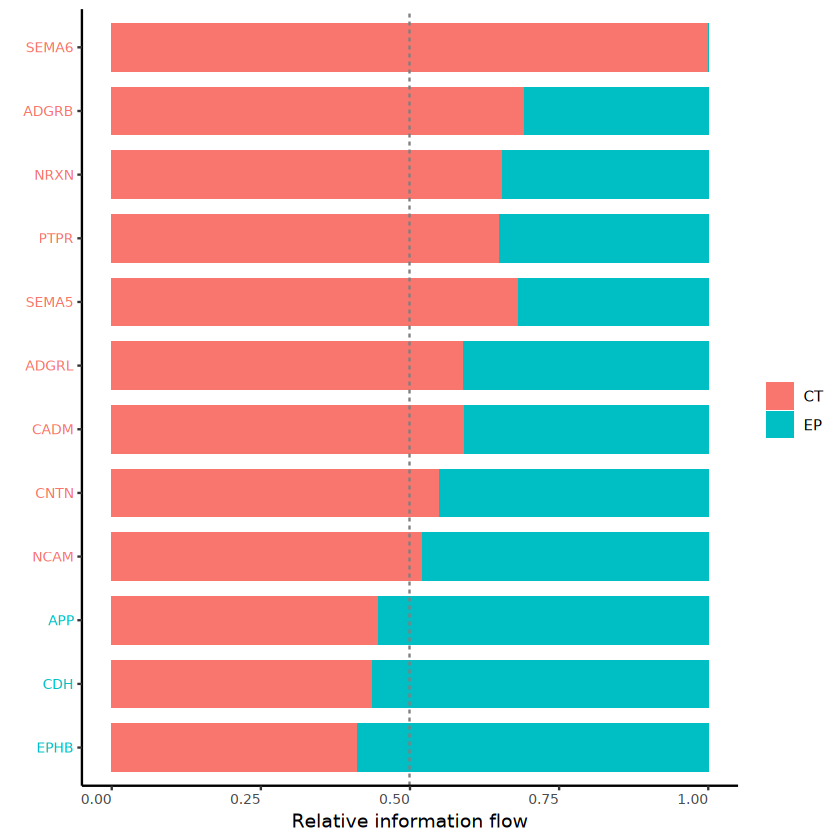

In [101]:
gg1 <- rankNet(cellchat, mode = "comparison", measure = "weight", sources.use = "037 DG Glut", targets.use = "017 CA3 Glut", stacked = T, do.stat = TRUE)
gg1

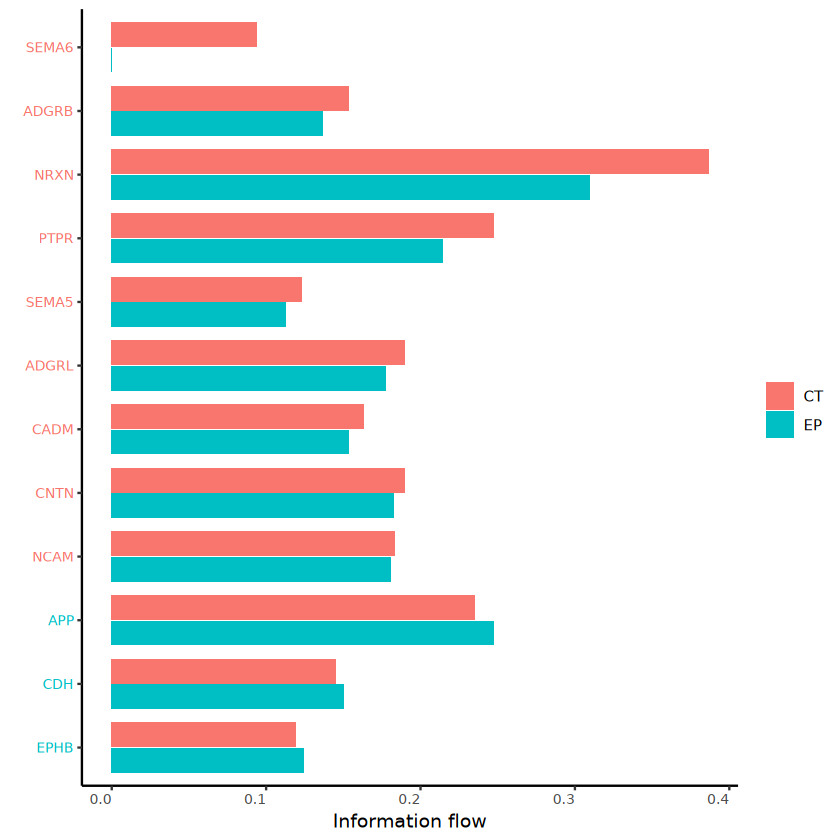

In [113]:
gg2 <- rankNet(cellchat, mode = "comparison", measure = "weight", sources.use = "037 DG Glut", targets.use = "017 CA3 Glut", stacked = F, do.stat = TRUE)
gg2

### 6.1.2 Visualize the identified down-regulated signaling ligand-receptor pairs from "037 DG Glut" to "017 CA3 Glut". 鉴定"037 DG Glut"到"017 CA3 Glut"的下调信号的配受体对

In [32]:
# define a positive dataset, i.e., the dataset with positive fold change against the other dataset
pos.dataset = "EP"
# define a char name used for storing the results of differential expression analysis
features.name = paste0(pos.dataset, ".merged")

# perform differential expression analysis 
# Of note, compared to CellChat version < v2, CellChat v2 now performs an ultra-fast Wilcoxon test using the presto package, which gives smaller values of logFC. Thus we here set a smaller value of thresh.fc compared to the original one (thresh.fc = 0.1). Users can also provide a vector and dataframe of customized DEGs by modifying the cellchat@var.features$LS.merged and cellchat@var.features$LS.merged.info. 

cellchat <- identifyOverExpressedGenes(cellchat, group.dataset = "datasets", pos.dataset = pos.dataset, features.name = features.name, only.pos = FALSE, thresh.pc = 0.1, thresh.fc = 0.05,thresh.p = 0.05, group.DE.combined = FALSE) 
#> Use the joint cell labels from the merged CellChat object

# map the results of differential expression analysis onto the inferred cell-cell communications to easily manage/subset the ligand-receptor pairs of interest
net <- netMappingDEG(cellchat, features.name = features.name, variable.all = TRUE)
# extract the ligand-receptor pairs with upregulated ligands in EP
# There is no up-regulated signaling ligand-receptor pairs
#net.up <- subsetCommunication(cellchat, net = net, datasets = "EP",ligand.logFC = 0.05, receptor.logFC = NULL)
# extract the ligand-receptor pairs with upregulated ligands and upregulated receptors in NL, i.e.,downregulated in LS
net.down <- subsetCommunication(cellchat, net = net, datasets = "CT",ligand.logFC = -0.05, receptor.logFC = NULL)

Use the joint cell labels from the merged CellChat object



In [77]:
unique(cellchat@idents[[1]])

[1] 016 CA1-ProS Glut  038 DG-PIR Ex IMN  319 Astro-TE NN    037 DG Glut       
[5] 318 Astro-NT NN    017 CA3 Glut       025 CA2-FC-IG Glut 334 Microglia NN  
8 Levels: 016 CA1-ProS Glut 017 CA3 Glut 025 CA2-FC-IG Glut ... 334 Microglia NN

Comparing communications on a merged object 




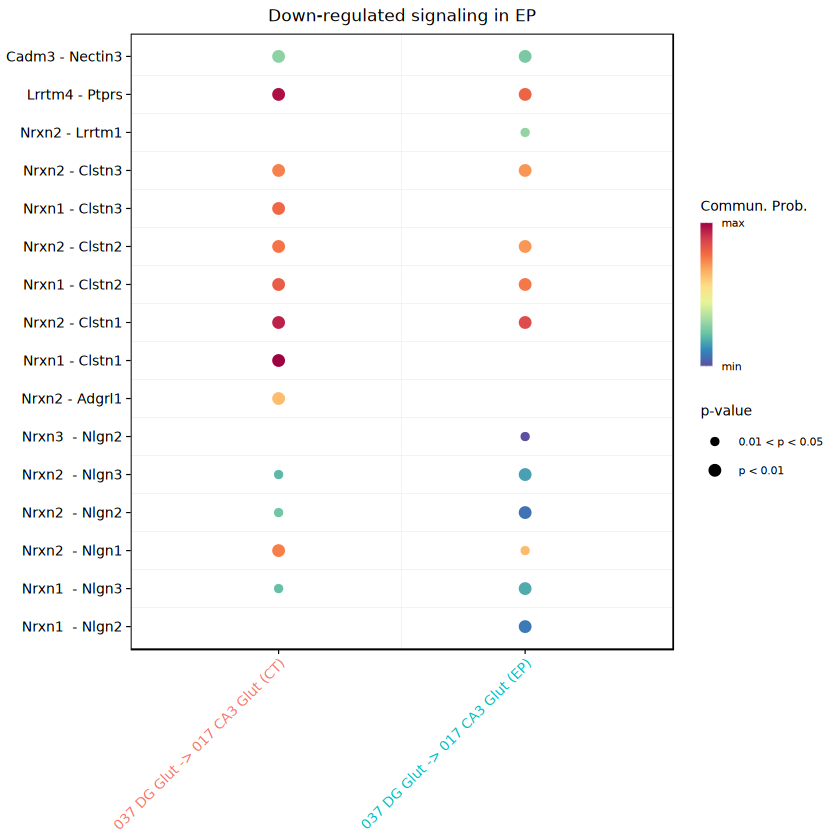

In [114]:
pairLR.use.down = net.down[, "interaction_name", drop = F]
gg2 <- netVisual_bubble(cellchat, pairLR.use = pairLR.use.down, sources.use = "037 DG Glut", targets.use = c("017 CA3 Glut"), 
                        comparison = c(1, 2), angle.x = 45, remove.isolate = T,title.name = paste0("Down-regulated signaling in ", names(object.list)[2]))
gg2

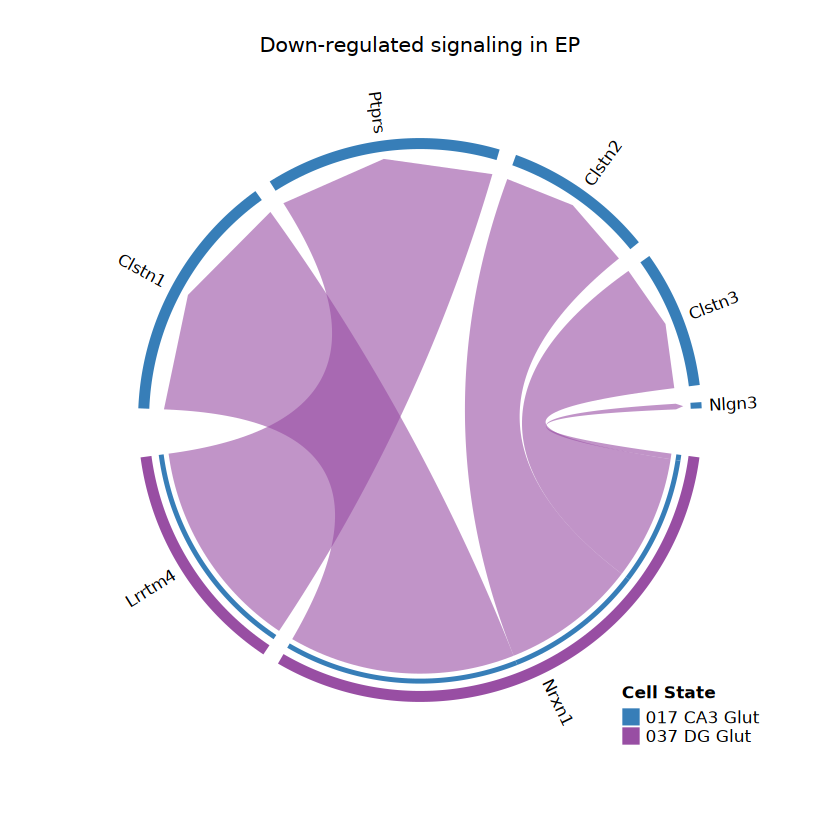

In [117]:
# Chord diagram
gg2 <- netVisual_chord_gene(object.list[[1]], sources.use = "037 DG Glut", targets.use = c("017 CA3 Glut"), 
                     slot.name = 'net', net = net.down, lab.cex = 0.8, small.gap = 3.5, title.name = paste0("Down-regulated signaling in ", names(object.list)[2]))
#> You may try the function `netVisual_chord_cell` for visualizing individual signaling pathway

## 6.1.3 Visually compare cell-cell communication using Circle plot 使用圈图来比较"NRXN"通路中不同数据集的差异

Edge colors are consistent with the sources as sender, and edge weights are proportional to the interaction strength. Thicker edge line indicates a stronger signal.
边的颜色与发送方来源一致，边的权重与相互作用强度成正比。更粗的边线表示信号更强。

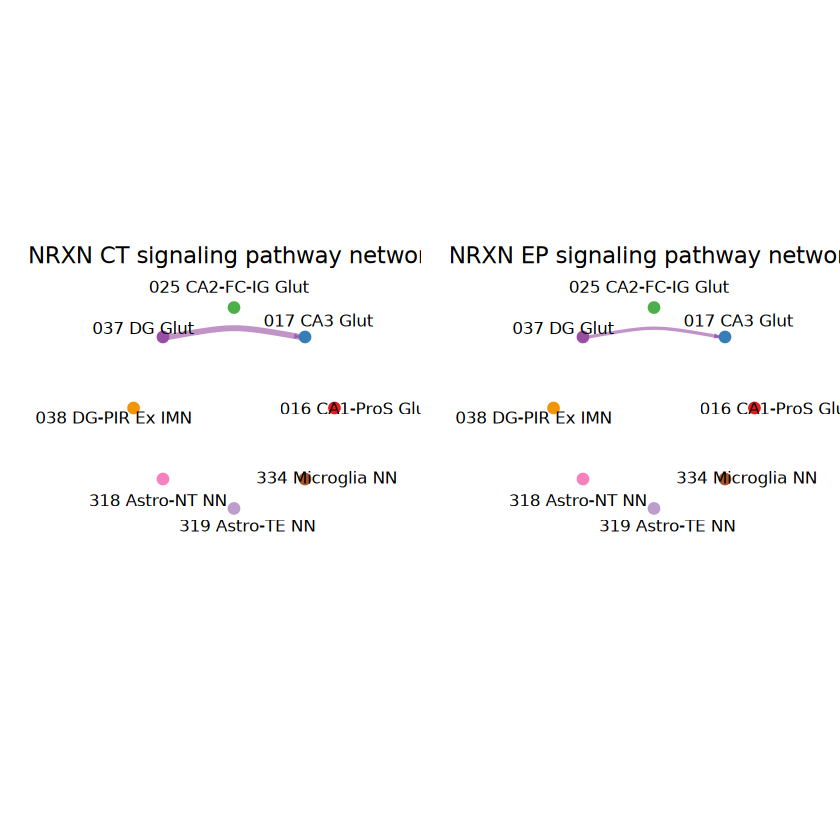

In [104]:
pathways.show <- c("NRXN") 
weight.max <- getMaxWeight(object.list, slot.name = c("netP"), attribute = pathways.show) # control the edge weights across different datasets
par(mfrow = c(1,2), xpd=TRUE)
for (i in 1:length(object.list)) {
  netVisual_aggregate(object.list[[i]], signaling = pathways.show, sources.use = 4,targets.use = c("017 CA3 Glut"),layout = "circle", edge.weight.max = weight.max[1], edge.width.max = 10, signaling.name = paste(pathways.show, names(object.list)[i]))
}

### 6.1.4 Summary 总结:  

In the neural circuit of the hippocampus, signals from the entorhinal cortex (EC) first reach the dentate gyrus (DG). The axons of EC neurons form synaptic connections with the granule cells of the DG through the perforant path. When EC neurons are excited, they release the neurotransmitter glutamate, which activates the DG granule cells. Once the DG granule cells are activated, their axons, known as mossy fibers, transmit signals to the CA3 region. The mossy fibers form excitatory synapses with CA3 neurons, releasing glutamate and thus activating the CA3 neurons, completing the information transfer process from the DG to the CA3.  

  在海马体的神经回路中，内嗅皮层（EC）的信号首先到达 DG。EC 神经元的轴突通过穿孔通路与 DG 的颗粒细胞形成突触连接。当 EC 神经元兴奋时，释放神经递质谷氨酸，激活 DG 颗粒细胞。DG 颗粒细胞被激活后，其轴突（即苔藓纤维）会将信号传递至 CA3 区域。苔藓纤维与 CA3 神经元形成兴奋性突触，释放谷氨酸，进而激活 CA3 神经元，完成从 DG 到 CA3 的信息传递过程。  
  
During the interaction between "037 DG Glut" and "017 CA3 Glut", we can observe a significant downregulation of interactions in signaling pathways such as NRXNd. Among the ligand-receptor pairs with downregulated signals, multiple ligand-receptor pairs of NRXN also show differences. This includes differences in the interaction strengths between Nrxn1 and receptors Clstn1, Clstn2, Clstn3, and Nlgn3. Clstn3 is a postsynaptic adhesion molecule that can induce presynaptic differentiation through presynaptic Neurexins (Nrxns). β-Nrxns directly interact with the cadherin domains of Clstn3 and Clstn3 through their LNS domains, inducing presynaptic differentiation and coordinating the development of excitatory synapses [1]. Neurexin1 (Nrxn1) is a neuron-specific synaptic protein. As a presynaptic cell adhesion molecule, it participates in the connection and signal transmission between the presynaptic and postsynaptic membranes, providing a basis for the stable structure of synapses. It regulates the release of neurotransmitters and the efficiency of synaptic transmission by interacting with multiple postsynaptic receptors [2].  

  在"037 DG Glut"与"017 CA3 Glut"的互作过程中，我们可以看到NRXNd等信号通路中表现出互作显著下调。在下调信号的配受体对中NRXN的多个配受体对也表现出差异。包括Nrxn1与受体Clstn1, Clstn2, Clstn3, Nlgn3之间的互作强度差异。Clstn3 是一种突触后粘附分子，它能够通过突触前的 Neurexins（Nrxns）诱导突触前分化。β-Nrxns 直接通过其 LNS 结构域与 Clstn3 和 Clstn3 的钙粘蛋白结构域相互作用，诱导突触前分化并协调兴奋性突触的发育[1]。Neurexin1（Nrxn1）是一种神经特异性突触蛋白，作为突触前的细胞粘附分子，参与突触前膜和突触后膜之间的连接和信号传递，为突触的稳定结构提供基础。通过与多种突触后受体相互作用，调节神经递质的释放和突触传递的效率[2]。  

This indicates that short-term sleep deprivation can affect the synaptic connections and signal conduction from the DG to the CA3. This downregulated signal conduction process may play a role in the learning and memory deficits caused by short-term sleep deprivation.   

这提示短暂的睡眠剥夺就会影响从DG到CA3的突触连接和信号传导，这提示这种下调的信号传导过程可能在短暂的睡眠剥夺导的学习和记忆缺失中起作用。 

References 参考文献：  
1.Kim, Hyeonho, et al. "Calsyntenin-3 interacts with both α-and β-neurexins in the regulation of excitatory synaptic innervation in specific Schaffer collateral pathways." Journal of Biological Chemistry 295.27 (2020): 9244-9262. 
2.Zhonghua Hu,Xiao Xiao,Zhuohua Zhang,Ming Li. "Genetic insights and neurobiological implications from NRXN1 in neuropsychiatric disorders." Molecular psychiatry 10(2019).

### 6.2 Compare the interaction of from "017 CA3 Glut" cell type to "016 CA1-ProS Glut" 比较"017 CA3 Glut" 到"016 CA1-ProS Glut"的突触互作的影响

#### 6.2.1 Compare the information flow of NRXN from "017 CA3 Glut" cell type to "016 CA1-ProS Glut"

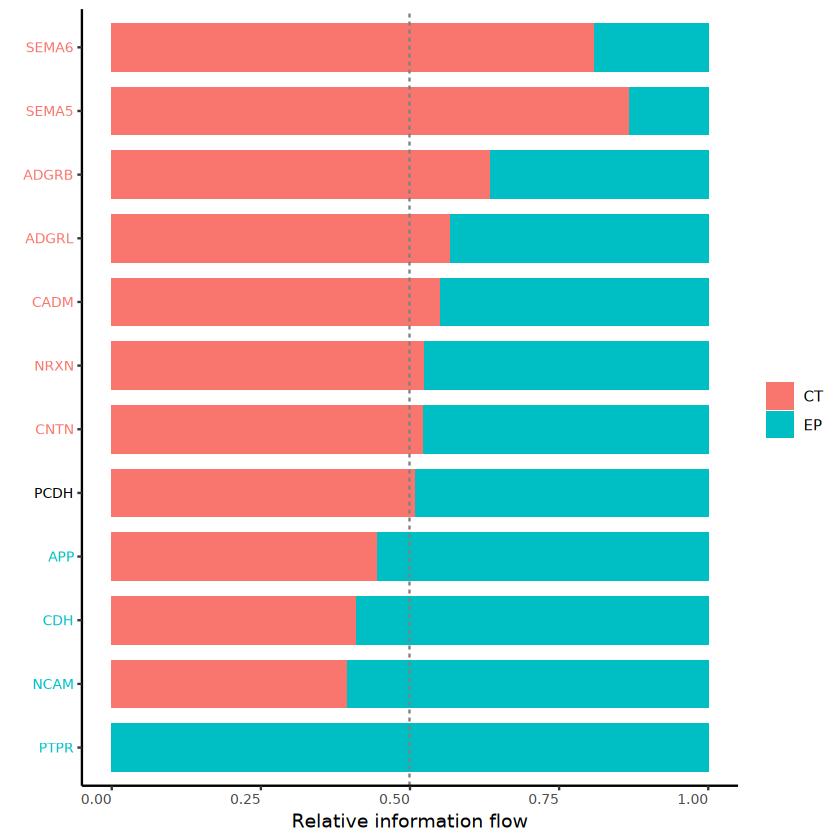

In [124]:
gg1 <- rankNet(cellchat, mode = "comparison", measure = "weight", sources.use = "017 CA3 Glut", targets.use = "016 CA1-ProS Glut", stacked = T, do.stat = TRUE)
gg1

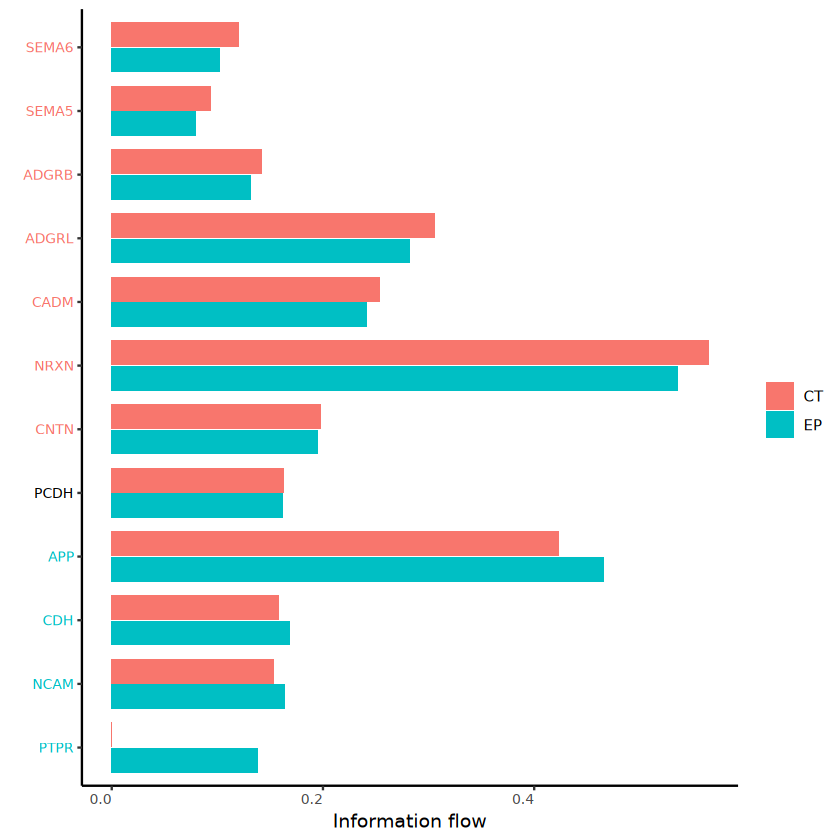

In [121]:
gg1 <- rankNet(cellchat, mode = "comparison", measure = "weight", sources.use = "017 CA3 Glut", targets.use = "016 CA1-ProS Glut", stacked = F, do.stat = TRUE)
gg1

### 6.2.2 Visualize the identified down-regulated signaling ligand-receptor pairs from "017 CA3 Glut" cell type to "016 CA1-ProS Glut". 鉴定"017 CA3 Glut" cell type 到 "016 CA1-ProS Glut"的下调信号的配受体对

Comparing communications on a merged object 




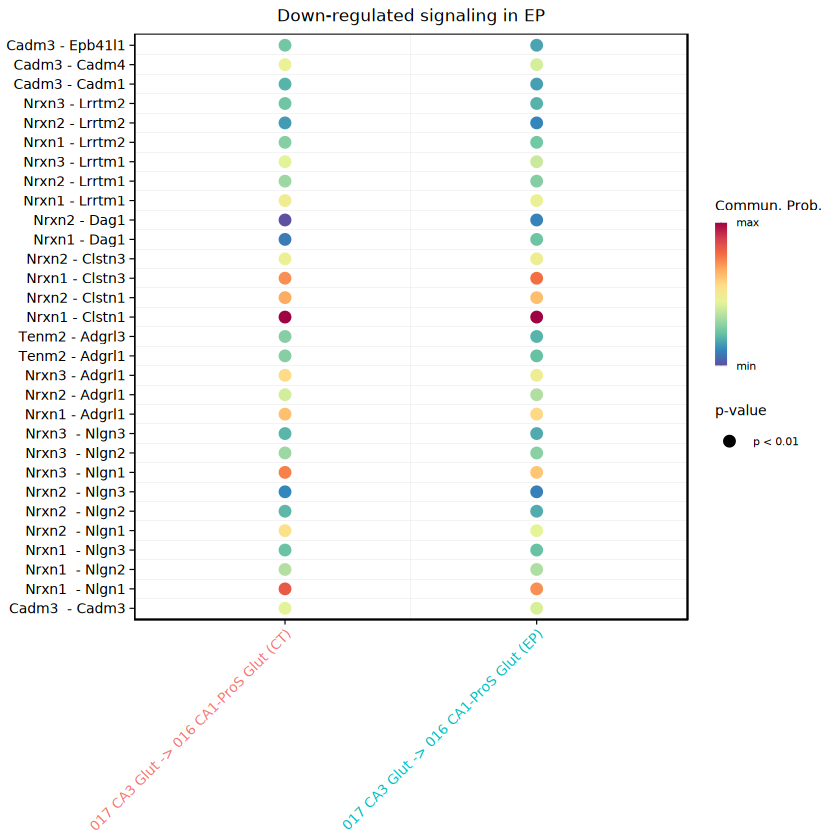

In [120]:
pairLR.use.down = net.down[, "interaction_name", drop = F]
gg2 <- netVisual_bubble(cellchat, pairLR.use = pairLR.use.down, sources.use = "017 CA3 Glut", targets.use = "016 CA1-ProS Glut", 
                        comparison = c(1, 2), angle.x = 45, remove.isolate = T,title.name = paste0("Down-regulated signaling in ", names(object.list)[2]))
gg2

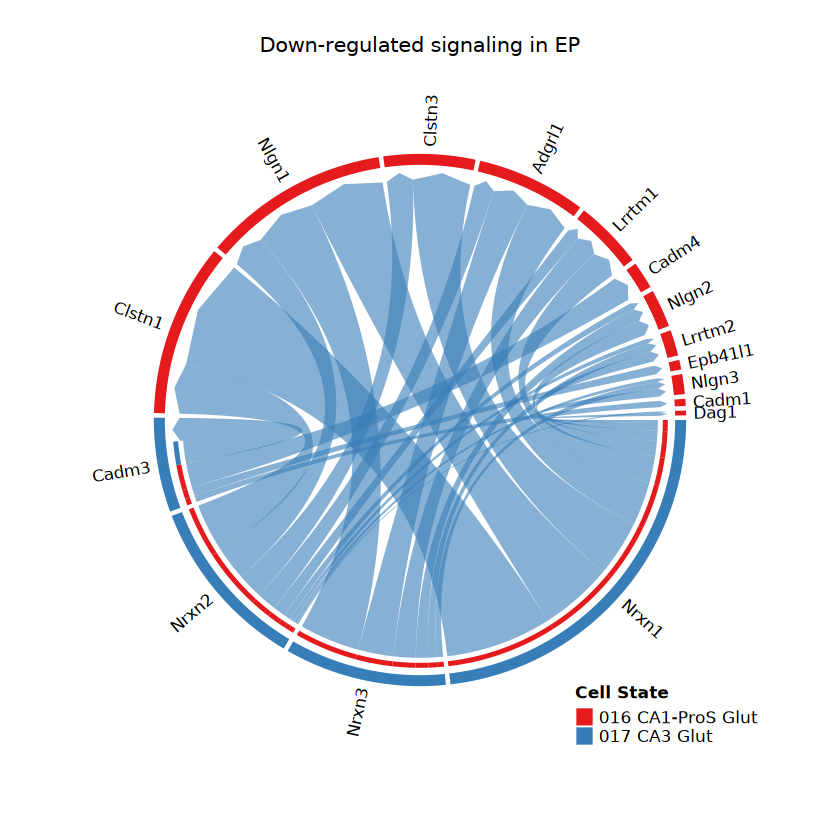

In [119]:
# Chord diagram
gg2 <- netVisual_chord_gene(object.list[[1]], sources.use = "017 CA3 Glut", targets.use = "016 CA1-ProS Glut", 
                     slot.name = 'net', net = net.down, lab.cex = 0.8, small.gap = 3.5, title.name = paste0("Down-regulated signaling in ", names(object.list)[2]))
#> You may try the function `netVisual_chord_cell` for visualizing individual signaling pathway

## 6.2.3 Visually compare cell-cell communication using Circle plot 使用圈图来比较"NRXN"通路中不同数据集的差异

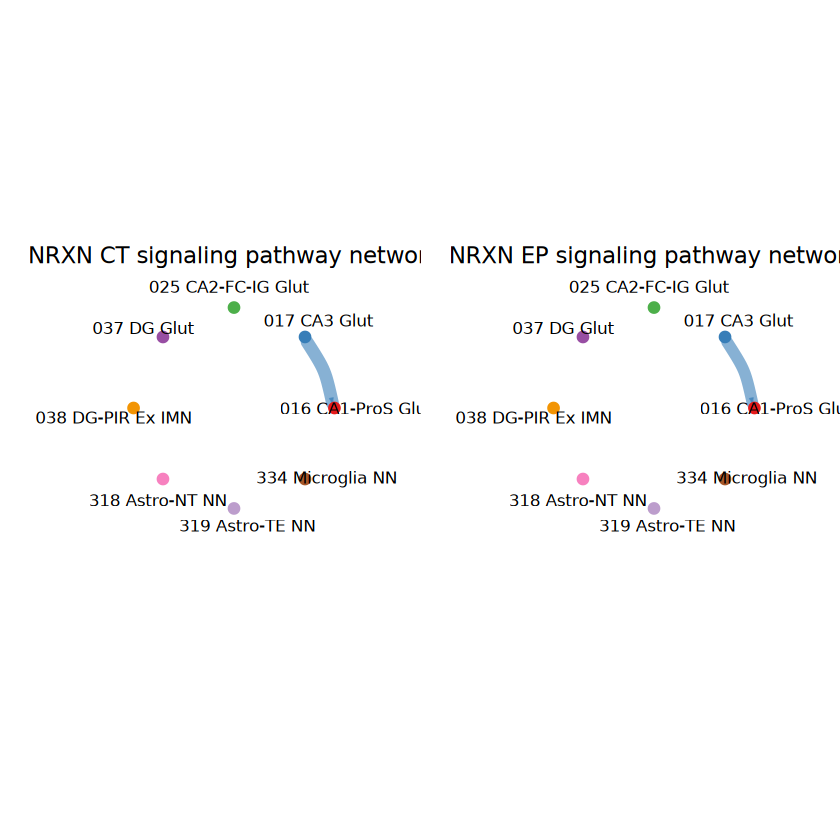

In [127]:
pathways.show <- c("NRXN") 
weight.max <- getMaxWeight(object.list, slot.name = c("netP"), attribute = pathways.show) # control the edge weights across different datasets
par(mfrow = c(1,2), xpd=TRUE)
for (i in 1:length(object.list)) {
  netVisual_aggregate(object.list[[i]], signaling = pathways.show, layout = "circle",sources.use = "017 CA3 Glut", targets.use = "016 CA1-ProS Glut", edge.weight.max = weight.max[1], edge.width.max = 10, signaling.name = paste(pathways.show, names(object.list)[i]))
}

### 6.2.4 Summary 总结：  

  LRRTMs are a family of four postsynaptic transmembrane proteins that guide the presynaptic differentiation of contacting axons and mediate the postsynaptic recruitment of scaffold proteins and neurotransmitter receptors. In the hippocampus, LRRTM1 and LRRTM2 are the family members specifically expressed in the CA1 region [1]. Nrxn1β binds to the C-terminal cap of LRRTM2, and the interaction between them is mediated by Ca²⁺. The key residues for the binding of LRRTM1 and LRRTM2 to Nrxn1β are completely conserved [2]. In LRRTM1/2-DKO mice, the number of excitatory synapses and spines in the CA1 region is reduced, the frequency of mEPSC in pyramidal neurons is decreased, the LTP of the CA3-CA1 pathway in mice is impaired, and the contextual fear memory is reduced [3]. During the interaction between "017 CA3 Glut" and "016 CA1-ProS Glut", we can observe a significant downregulation of interactions in signaling pathways such as NRXN. Among the ligand-receptor pairs with downregulated signals, multiple ligand-receptor pairs of NRXN also show differences. This includes a decrease in the interaction strength between Nrxn1 and the receptors LRRTM1 and LRRTM2 after sleep deprivation. This suggests that short-term sleep deprivation may reduce the strength of signal transmission by decreasing the interaction from CA3 to CA1, thereby leading to memory impairment or LTP damage.

  LRRTMs是一个包含四种突触后跨膜蛋白的家族，它们指导与之接触的轴突进行突触前分化，并介导突触后对支架蛋白和递质受体的募集。在海马体中，LRRTM1 和 LRRTM2 是 CA1 区域中特异性表达的家族成员[1]。Nrxn1β 与 LRRTM2 的 C 端帽结合，Ca²⁺介导二者相互作用，LRRTM1 与 LRRTM2 和 Nrxn1β 结合的关键残基完全保守[2]。LRRTM1/2-DKO 小鼠 CA1 区兴奋性突触和棘突数量减少，锥体神经元 mEPSC 频率降低，小鼠 CA3-CA1 通路 LTP 受损，情境恐惧记忆减退[3]。在"017 CA3 Glut"与016 CA1-ProS Glut的互作过程中，我们可以看到NRXN等信号通路中表现出互作显著下调。在下调信号的配受体对中NRXN的多个配受体对也表现出差异。包括Nrxn1与受体LRRTM1和LRRTM2之间的互作强度在睡眠剥夺后见底。这提示短时间的睡眠剥夺可能会通过降低CA3到CA1的互作关系来降低信号传递强度，从而导致记忆损伤或LTP受损。  

References 参考文献：  
1.Roppongi, Reiko T., Benyamin Karimi, and Tabrez J. Siddiqui. "Role of LRRTMs in synapse development and plasticity." Neuroscience Research 116 (2017): 18-28.  
2.Atsushi Yamagata,Sakurako Goto-Ito,Yusuke Sato,Tomoko Shiroshima,Asami Maeda. "Structural insights into modulation and selectivity of transsynaptic neurexin-LRRTM interaction." Nature communications 1(2018).  
3.Um, Ji Won, et al. "Calsyntenins function as synaptogenic adhesion molecules in concert with neurexins." Cell reports 6.6 (2014): 1096-1109.